# Проект для "Викишоп" с BERT

# ВВЕДЕНИЕ

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.
Требуется обучить модель классифицировать комментарии на позитивные и негативные. Исходные данные содержат разметку  токсичности правок.
Предполагается, что построенная модель будет иметь метрику качества F1 не меньше 0.75.

# Загрузка данных

Установка библиотек.

In [1]:
!pip install imblearn -q

In [2]:
!pip install wordcloud  -q

In [3]:
!pip install transformers_interpret -q

In [4]:
!pip install numpy==1.26.4

In [5]:
import os
import time
import torch
import re

import pandas as pd
import nltk

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from tqdm import notebook
import copy

from nltk.corpus import stopwords as nltk_stopwords
from transformers import AutoModel, AutoTokenizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import f_classif, mutual_info_classif,SelectKBest
from sklearn.inspection import permutation_importance

from sklearn.model_selection import train_test_split

from sklearn.metrics import (
     accuracy_score,
     confusion_matrix,
     f1_score,
     ConfusionMatrixDisplay
)

from wordcloud import WordCloud
import transformers

import nltk
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize


from sklearn.pipeline import Pipeline

RANDOM_STATE = 42
TEST_SIZE = 0.5

[nltk_data] Downloading package wordnet to /root/nltk_data...


Загрузка данных.

In [6]:
pth1 = 'toxic_comments.csv'
pth2 = 'https://code.s3.yandex.net/datasets/toxic_comments.csv'

try:
    data = pd.read_csv(pth1)
except:
    data = pd.read_csv(pth2)

Просмотр загруженного датафрейма.

In [7]:
display(data.head(10))

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
5,5,"""\n\nCongratulations from me as well, use the ...",0
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,7,Your vandalism to the Matt Shirvington article...,0
8,8,Sorry if the word 'nonsense' was offensive to ...,0
9,9,alignment on this subject and which are contra...,0


Общая информация о датафрейме, проверка на дубликаты и пропуски.

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [9]:
data.duplicated().sum()

0

In [10]:
data.isna().sum()

,0
Unnamed: 0,0
text,0
toxic,0


Посмотрим, сколько всего токсичных комментариев в выборке.

In [11]:
data['toxic'].sum()/data['toxic'].count()

0.10161213369158527

Около 10%, значит у нас будет сильный дисбаланс классов, который надо будет учесть при построении модели классификации.

 Сначала решим задачу классификации твитов, применив векторные представления на базе BERT. Построить векторы текстов нам поможет предобученная на токсичных  текстах модель toxic-bert.

# BERT

Таблица содержит почти 160 тысяч строк, это очень много для моделей обработки текста. Ограничимся случайной выборкой из 800 строк, посмотрим, как на них отработает модель.

In [12]:
data_tox = data[data['toxic']==1]

In [13]:
data_copy = data.copy(deep=True)#создадим копию исходного датафрейма

In [14]:
data = data.sample(800).reset_index(drop=True)

Создаем список слов из корпуса токсичных комментариев и список слов из нейтральных.

In [15]:
data_good = data[data['toxic']==0]

corpus_tox = list(data_tox['text'])
corpus_good = list(data_good['text'])

tox = ' '.join(corpus_tox)
good = ' '.join(corpus_good)

Построим облако слов отдельно для токсичных и для нейтральных комментариев для более наглядного представления.

Облако слов для токсичных комментариев (по всей выборке).

Затрачено времени: 275.934533244 сек


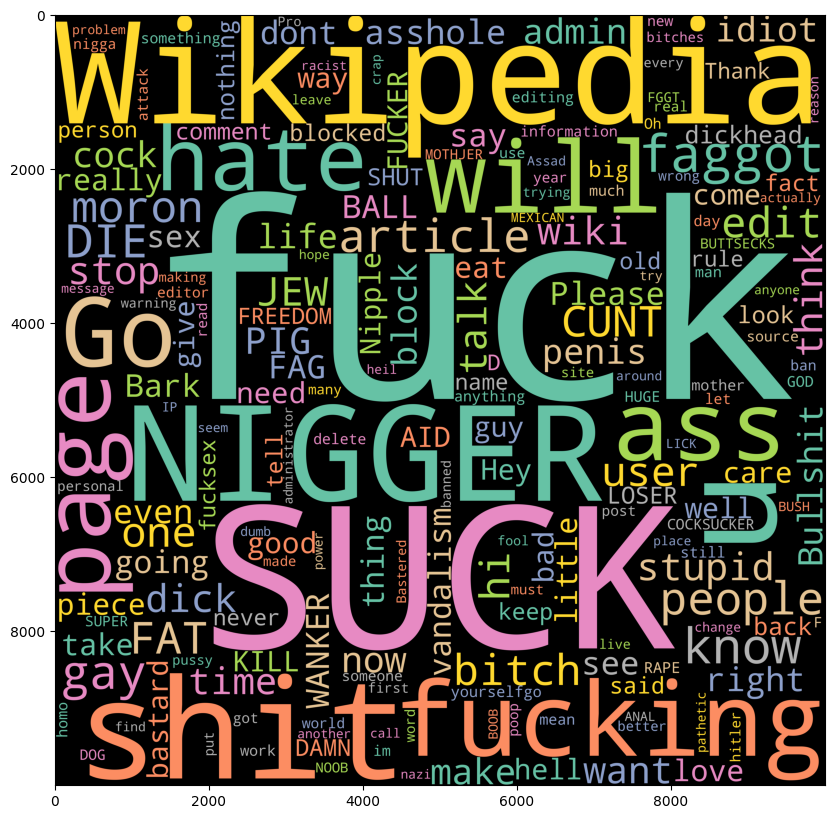

In [16]:
start = time.perf_counter()

wordCloud = WordCloud(width = 10000, height = 10000, random_state=1, background_color='black', colormap='Set2', collocations=False).\
             generate(tox)
plt.figure(figsize=(10,10))
plt.imshow(wordCloud)

end=time.perf_counter()
elapsed =end - start
print(f"Затрачено времени: {elapsed} сек")

Облако слов для нейтральных комментариев (по сэмплированной выборке).

Затрачено времени: 231.93262769199998 сек


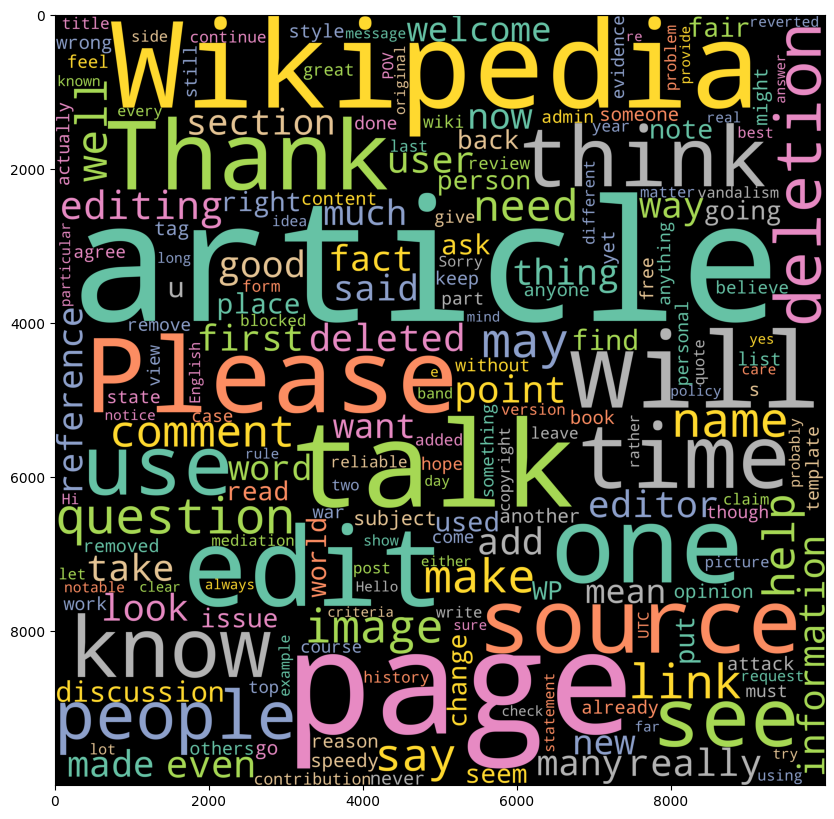

In [17]:
start=time.perf_counter()

wordCloud = WordCloud(width = 10000, height = 10000, random_state=1, background_color='black', colormap='Set2', collocations=False).\
             generate(good)
plt.figure(figsize=(10,10))
plt.imshow(wordCloud)

end=time.perf_counter()
elapsed =end - start
print(f"Затрачено времени: {elapsed} сек")

Загружаем список стоп-слов английского языка.

In [18]:
nltk.download('stopwords')

stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Создаем корпус текстов.

In [19]:
corpus = list(data['text'])

Функция для очистки текста от ненужных символов.

In [20]:
def clear_text(text):
    t=re.sub(r'[^a-zA-Z]', ' ', text)
    t=t.split()
    return ' '.join(t)

Теперь применяем эту функцию к каждому предложению из корпуса.

In [21]:
a = []
for i in corpus:
    a.append(clear_text(i))

Переписываем столбец data['text'] и проверяем корректность нашей обработки.

In [22]:
data['text'] = a

In [23]:
display(data.head(10))

,Unnamed: 0,text,toxic
0,148894,Your user name or IP address has been blocked ...,0
1,21766,You reported and they were blocked for days Th...,0
2,117634,Max The principal definition of Semi President...,0
3,149357,I will write a piece on William Jarvis thanks ...,0
4,43064,There were several links in this section to di...,0
5,85945,Apparently the write did not get permission fr...,0
6,156365,with their origins in Europe,0
7,133756,I will follow the guidelines as they are But w...,1
8,71190,marathas are not rajputs Marathas are not rajp...,0
9,131044,GA Review This review is transcluded from Talk...,0


Таким образом, наш текст очищен от лишних символов, теперь к нему можно применять модель для создания признаков для задачи классификации и прогноза токсичности отзывов.

### Подготовка признаков для задачи классификации


Преобразуем исходные тексты в векторы, которые и будут признаками в задаче классификации. Для этого используем предобученную модель "unitary/toxic-bert".

Инициализируем модель и токенизатор, который разбивает и преобразует исходные тексты в список токенов.

In [24]:
model_name = "unitary/toxic-bert"

model = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/811 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/174 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Преобразуем текст в номера токенов с помощью токенайзера.

Параметр add_special_tokens = True,значит, что к любому преобразуемому тексту добавляется токен начала (101) и токен конца текста (102).

Параметры truncation=True,max_length=512 означают, что последовательности усекаются до максимальной длины 512 токенов.

In [25]:
tokenized = data['text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens = True,truncation = True, max_length = 512))

Посмотрим, как прошла токенизация.

In [26]:
display(tokenized)

,text
0,"[101, 2115, 5310, 2171, 2030, 12997, 4769, 203..."
1,"[101, 2017, 2988, 1998, 2027, 2020, 8534, 2005..."
2,"[101, 4098, 1996, 4054, 6210, 1997, 4100, 4883..."
3,"[101, 1045, 2097, 4339, 1037, 3538, 2006, 2520..."
4,"[101, 2045, 2020, 2195, 6971, 1999, 2023, 2930..."
...,...
795,"[101, 3314, 2138, 2122, 3924, 2024, 9832, 2000..."
796,"[101, 4931, 4283, 2005, 15591, 2006, 2026, 474..."
797,"[101, 5202, 11510, 2026, 10086, 2015, 2020, 20..."
798,"[101, 4487, 10536, 22196, 2271, 15772, 2003, 4..."


Каждая строка преобразована в список чисел.

Теперь применим метод padding, чтобы после токенизации длины исходных текстов в корпусе были равным (условие для работы BERT). Пусть стандартной длиной вектора n будет длина наибольшего во всём датасете вектора. Остальные векторы дополним нулями.

In [27]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

In [28]:
padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

Теперь поясним модели, что нули не несут значимой информации. Создадим attention_mask, массив из 0 и 1, который  указывает модели, какие токены следует учитывать (1), а какие игнорировать(0).

In [29]:
attention_mask = np.where(padded != 0, 1, 0)

Проверим размерности полученных массивов.

In [30]:
np.array(padded).shape

(800, 512)

In [31]:
attention_mask.shape

(800, 512)

Теперь преобразуем тексты в векторы-эмбеддинги, которые содержат данные о соотношении разных слов и их свойствах.

Сделаем цикл по батчам, на каждом шаге преобразуем данные и маску в формат тензоров и передаем их модели unitary/toxic-bert, которая преобразует их в эмбеддинги, и эти эмбеддинги заносятся в список embeddings.

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [33]:
model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [34]:
token_ids = torch.tensor(padded).to(device)
attentionMask = torch.tensor(attention_mask ).to(device)

In [35]:
def get_text_embeddings(data, tokenizer, model, device, max_len=512, batch_size=50):

  # Токенизируем данные
  tokenized = data['text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True,truncation=True, max_length=max_len))
  padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])
  attention_mask = np.where(padded != 0, 1, 0)

  # Получаем эмбендинги
  text_embeddings = {}
  embeddings=[]

  for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
    batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]).to(device)
    attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)]).to(device)

    with torch.no_grad():
      model.to(device)
      batch_embeddings = model(batch, attention_mask=attention_mask_batch)

      embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())

  return embeddings

# получаем векторы
text_embeddings = get_text_embeddings(data, tokenizer, model, device, max_len=512, batch_size=1)

  0%|          | 0/800 [00:00<?, ?it/s]

Соберём все эмбеддинги в матрицу признаков features, проверим размерность матрицы и целевого признака и выведем на печать полученные признаки.

In [36]:
features = np.concatenate(text_embeddings)

print(features.shape[0])
print(data['toxic'].shape[0])


800
800


Как видим, преобразование прошло корректно.  Теперь на этих признаках можно обучать модель классификации.

### Подбор модели классификации

Поскольку у нас наблюдается сильный дисбаланс классов в целевом признаке, нужно стратифицировать тренировочную и тестовую выборки, чтобы они сохранили соотношение классов исходных данных. Соотношение тренировочной и тестовой выборки возьмем 1:1.

In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    features,
    data['toxic'],
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE,
    stratify=data['toxic']
)

Проверим размеры выборок.

In [38]:
print(X_train.shape[0])
print(X_test.shape[0])

400
400


Проверим, соблюдены ли пропорции классов в тренировочной и тестовой выборке.

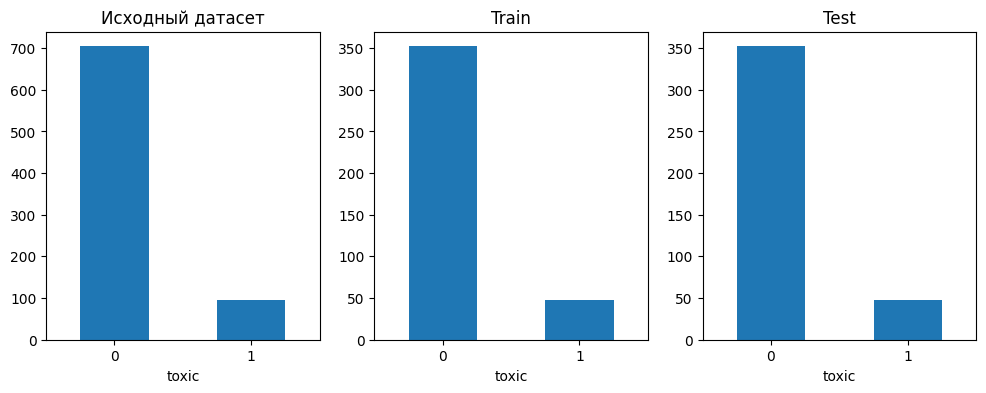

In [39]:
fig, ax = plt.subplots(1,3, figsize=(12,4))
data['toxic'].value_counts().plot(kind='bar', ax=ax[0], rot=0)
ax[0].set_title("Исходный датасет")
y_train.value_counts().plot(kind='bar', ax=ax[1], rot=0)
ax[1].set_title("Train")
y_test.value_counts().plot(kind='bar', ax=ax[2], rot=0)
ax[2].set_title("Test")
plt.show()

Как видим, пропорции соблюдены верно.

Создадим словарь для моделей, из которых  будем  выбирать лучшую по метрике f1. Для всех моделей, кроме KNeighborsClassifier применим взвешивание классов для решения проблемы дисбаланса классов.

In [40]:
param_distributions = [
    #словарь для модели KNeighborsClassifier()
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 20),
        'models__weights': ['uniform', 'distance'],

     },
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state = RANDOM_STATE, class_weight = 'balanced')],
        'models__min_samples_leaf': range(1, 10),



    },
    # словарь для модели SVC()
    {
        'models': [SVC(random_state = RANDOM_STATE, probability = True, class_weight = 'balanced')],
        'models__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],


    },
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(random_state = RANDOM_STATE, class_weight = 'balanced', max_iter = 1000)],
        'models__C': [0.5,1,2,3,4,5,6,7,8,9,10],
        'models__solver': ['liblinear', 'saga'],

    },
]

In [41]:
pipe_final = Pipeline([

    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

Случайный поиск наилучшей модели с кросс-валидацией на 5 выборках по метрике f1:

In [42]:
randomized_search_all = RandomizedSearchCV(
    pipe_final,
    param_distributions=param_distributions,
    scoring='f1',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    cv=5
)


In [43]:
randomized_search_all.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('models',
                                              DecisionTreeClassifier(random_state=42))]),
                   n_jobs=-1,
                   param_distributions=[{'models': [KNeighborsClassifier()],
                                         'models__n_neighbors': range(1, 20),
                                         'models__weights': ['uniform',
                                                             'distance']},
                                        {'models': [DecisionTreeClassifier(class_weight='balanced',
                                                                           random_state=42)],
                                         'models__min_samples_leaf': range(1, 10)},
                                        {'models': [SVC(class_weight='balanced',
                                                        probability=True,
                                                        random_state=42)],
                                         'models__kernel': ['linear', 'poly',
                                                            'rbf', 'sigmoid']},
                                        {'models': [LogisticRegression(class_weight='balanced',
                                                                       max_iter=1000,
                                                                       random_state=42)],
                                         'models__C': [0.5, 1, 2, 3, 4, 5, 6, 7,
                                                       8, 9, 10],
                                         'models__solver': ['liblinear',
                                                            'saga']}],
                   random_state=42, scoring='f1')

Выведем таблицу с результатами поиска наилучшей модели.

In [44]:
pd.set_option('display.max_colwidth', None)
result = pd.DataFrame(randomized_search_all.cv_results_)
display(result[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score'))

,rank_test_score,param_models,mean_test_score,params
9,1,"LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)",0.947251,"{'models__solver': 'liblinear', 'models__C': 2, 'models': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)}"
0,2,KNeighborsClassifier(),0.944960,"{'models__weights': 'uniform', 'models__n_neighbors': 3, 'models': KNeighborsClassifier()}"
1,3,"LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)",0.936725,"{'models__solver': 'liblinear', 'models__C': 6, 'models': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)}"
8,4,KNeighborsClassifier(),0.935487,"{'models__weights': 'uniform', 'models__n_neighbors': 7, 'models': KNeighborsClassifier()}"
6,5,KNeighborsClassifier(),0.934434,"{'models__weights': 'uniform', 'models__n_neighbors': 6, 'models': KNeighborsClassifier()}"
4,6,KNeighborsClassifier(),0.926013,"{'models__weights': 'uniform', 'models__n_neighbors': 15, 'models': KNeighborsClassifier()}"
5,7,"LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)",0.925146,"{'models__solver': 'saga', 'models__C': 10, 'models': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)}"
2,8,KNeighborsClassifier(),0.924960,"{'models__weights': 'uniform', 'models__n_neighbors': 10, 'models': KNeighborsClassifier()}"
7,8,KNeighborsClassifier(),0.924960,"{'models__weights': 'uniform', 'models__n_neighbors': 18, 'models': KNeighborsClassifier()}"
3,10,KNeighborsClassifier(),0.912895,"{'models__weights': 'uniform', 'models__n_neighbors': 1, 'models': KNeighborsClassifier()}"


Для каждой модели выведем ее лучшие параметры и метрики по убывающей.

In [45]:
result['param_models']=result['param_models'].astype('str')

Для логистической регрессии:

In [46]:
result_lr=result[result['param_models'].str.contains('Logistic')]

display(result_lr[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score'))

,rank_test_score,param_models,mean_test_score,params
9,1,"LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)",0.947251,"{'models__solver': 'liblinear', 'models__C': 2, 'models': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)}"
1,3,"LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)",0.936725,"{'models__solver': 'liblinear', 'models__C': 6, 'models': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)}"
5,7,"LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)",0.925146,"{'models__solver': 'saga', 'models__C': 10, 'models': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)}"


Для модели к-соседей:

In [47]:
result_kn=result[result['param_models'].str.contains('KNeighborsClassifier')]

display(result_kn[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score'))

,rank_test_score,param_models,mean_test_score,params
0,2,KNeighborsClassifier(),0.944960,"{'models__weights': 'uniform', 'models__n_neighbors': 3, 'models': KNeighborsClassifier()}"
8,4,KNeighborsClassifier(),0.935487,"{'models__weights': 'uniform', 'models__n_neighbors': 7, 'models': KNeighborsClassifier()}"
6,5,KNeighborsClassifier(),0.934434,"{'models__weights': 'uniform', 'models__n_neighbors': 6, 'models': KNeighborsClassifier()}"
4,6,KNeighborsClassifier(),0.926013,"{'models__weights': 'uniform', 'models__n_neighbors': 15, 'models': KNeighborsClassifier()}"
7,8,KNeighborsClassifier(),0.924960,"{'models__weights': 'uniform', 'models__n_neighbors': 18, 'models': KNeighborsClassifier()}"
2,8,KNeighborsClassifier(),0.924960,"{'models__weights': 'uniform', 'models__n_neighbors': 10, 'models': KNeighborsClassifier()}"
3,10,KNeighborsClassifier(),0.912895,"{'models__weights': 'uniform', 'models__n_neighbors': 1, 'models': KNeighborsClassifier()}"


Для SVC и DecisionTreeClassifier подходящие модели не нашлись:

In [48]:
result_SVC=result[result['param_models'].str.contains('SVC')]

display(result_SVC[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score'))

,rank_test_score,param_models,mean_test_score,params


In [49]:
result_Decision=result[result['param_models'].str.contains('Decision')]

display(result_Decision[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score'))

,rank_test_score,param_models,mean_test_score,params


Таким образом, наилучшей моделью по метрике f1 признана логистическая регрессия, ее средняя метрика оказалась 0.923.

### Тестирование лучшей модели

Теперь можем рассчитать метрику f1 на тестовой выборке.

In [50]:
y_pred=randomized_search_all.predict(X_test)

f1_score(y_test,y_pred)

0.94

Метрика удовлетворяет условиям задачи.

 Чтобы узнать, не предвзята ли наша модель, сравним её с такой, которая всегда присваивает объектам мажорный класс: DummyClassifier.

In [51]:
dummy_model = DummyClassifier(strategy = 'constant', constant = 1)

dummy_model.fit(X_train, y_train)

dummy_model_preds = dummy_model.predict(X_test)

dummy_f1 = f1_score(y_test, dummy_model_preds)
print('F1-score =', round(dummy_f1,2))

F1-score = 0.21


f1 = 0.22 на тестовой выборке.

Таким образом, наша модель прошла проверку на адекватность.

Для найденной наилучшей модели можно для наглядности вывести матрицу ошибок на тестовой выборке.

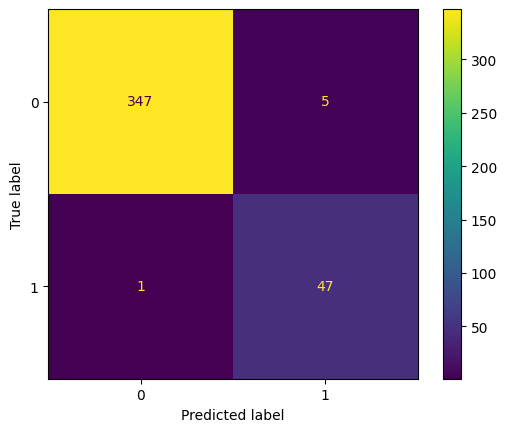

In [52]:
ConfusionMatrixDisplay.from_estimator(randomized_search_all, X_test, y_test)
plt.show()

Как видим, 1 токсичный отзыва модель приняла за нейтральные, а 5 нейтральных несправедливо отнесла к токсичным.

Теоретически, на этапе подбора модели можно было бы изменить порог вероятности, чтобы модель реже относила нейтральные отзывы к токсичным, тогда и ошибку FN можно было бы уменьшить. Но тогда нужно было бы выделять валидационную выборку и на ней подбирать порог, а у нас и так оказалось в наличии немного данных: на 800 строках программа работает около часа.


#  TFIDF

Теперь для интереса попробуем решить задачу без нейронной сети BERT.
У нас есть задача классификации, где целевой признак равен «1» для токсичного текста и «0» для отрицательного, а входные признаки — это слова из корпуса и их величины TF-IDF для каждого текста.

In [53]:
#достаем обратно исходный датафрейм
data=data_copy.copy(deep=True)

In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


Если для BERT не требовалось лемматизировать текст и очищать его от стоп-слов, то сейчас нам уже придется сделать это.

Функции для очищения от ненужных симловов, лемматизации и удаления  стоп-слов:

In [55]:
lemmatizer = WordNetLemmatizer()

def lemmatize(text):
    lemm_list=lemmatizer.lemmatize(text)
    lemm_text = "".join(lemm_list)

    return lemm_text

def clear_text(text):
    t=re.sub(r'[^a-zA-Z]', ' ', text)
    t=t.split()
    return ' '.join(t)

def remove_stopwords(text):
    text=text.split(' ')
    processed_word_list = []
    for word in text:
        word = word.lower()
        if word not in stopwords:
            processed_word_list.append(word)
    return ' '.join(processed_word_list)

Применяем эти функции к корпусу текстов:

In [56]:
a=[]

corpus = list(data['text'])

for i in corpus:
         a.append(remove_stopwords(lemmatize(clear_text(i))))

data['text']=a

In [57]:
display(data.head())

,Unnamed: 0,text,toxic
0,0,explanation edits made username hardcore metallica fan reverted vandalisms closure gas voted new york dolls fac please remove template talk page since retired,0
1,1,aww matches background colour seemingly stuck thanks talk january utc,0
2,2,hey man really trying edit war guy constantly removing relevant information talking edits instead talk page seems care formatting actual info,0
3,3,make real suggestions improvement wondered section statistics later subsection types accidents think references may need tidying exact format ie date format etc later one else first preferences formatting style references want please let know appears backlog articles review guess may delay reviewer turns listed relevant form eg wikipedia good article nominations transport,0
4,4,sir hero chance remember page,0


Создаем тренировочную и тестовые выборки, стратифицируя их по признаку 'toxic'.

In [58]:
X_train, X_test, y_train, y_test = train_test_split(
    data['text'],
    data['toxic'],
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE,
    stratify=data['toxic']
)

Будем подбирать гиперпараметры для логистической регрессии, параметры заданы в словаре:

In [59]:
params={
          'model__C':[.01,.05,.1,.5,1,5,10],
          'model__penalty':['l1','l2']}

Итоговый пайплайн, который состоит из

*   CountVectorizer - преобразователя текста в матрицу числовых данных,
*   TfidfTransformer - преобразователя матрицы в матрицу значений TF-IDF
*   модели логистической регрессии.



In [60]:
pipeline = Pipeline(
    [
    ('vect', CountVectorizer(min_df=40,ngram_range=(1,4))),
    ('tfidf', TfidfTransformer()),
    ('model',LogisticRegression())
    ])

Подбор гиперпараметров для логистической регрессии с помощью поиска по сетке GridSearchCV.

In [61]:
grid = GridSearchCV(
    pipeline,
    cv=5,
    n_jobs=-1,
    param_grid=params,
    scoring='f1')

grid.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
35 fits failed out of a total of 70.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **la

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(min_df=40,
                                                        ngram_range=(1, 4))),
                                       ('tfidf', TfidfTransformer()),
                                       ('model', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'model__C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10],
                         'model__penalty': ['l1', 'l2']},
             scoring='f1')

In [62]:
print('Метрика f1 на тестовой выборке ', grid.score(X_test, y_test))

Метрика f1 на тестовой выборке  0.7558551671415664


Метрика на тестовой выборке оказалась приемлемой.

Выведем лучшие модели и их параметры.

In [63]:
pd.set_option('display.max_colwidth', None)
result = pd.DataFrame(grid.cv_results_)
display(result[
    ['rank_test_score', 'params', 'mean_test_score','params']
].sort_values('rank_test_score'))

,rank_test_score,params,mean_test_score,params
13,1,"{'model__C': 10, 'model__penalty': 'l2'}",0.747560,"{'model__C': 10, 'model__penalty': 'l2'}"
11,2,"{'model__C': 5, 'model__penalty': 'l2'}",0.744536,"{'model__C': 5, 'model__penalty': 'l2'}"
9,3,"{'model__C': 1, 'model__penalty': 'l2'}",0.701197,"{'model__C': 1, 'model__penalty': 'l2'}"
7,4,"{'model__C': 0.5, 'model__penalty': 'l2'}",0.658186,"{'model__C': 0.5, 'model__penalty': 'l2'}"
5,5,"{'model__C': 0.1, 'model__penalty': 'l2'}",0.446415,"{'model__C': 0.1, 'model__penalty': 'l2'}"
3,6,"{'model__C': 0.05, 'model__penalty': 'l2'}",0.306859,"{'model__C': 0.05, 'model__penalty': 'l2'}"
1,7,"{'model__C': 0.01, 'model__penalty': 'l2'}",0.016178,"{'model__C': 0.01, 'model__penalty': 'l2'}"
2,8,"{'model__C': 0.05, 'model__penalty': 'l1'}",NaN,"{'model__C': 0.05, 'model__penalty': 'l1'}"
6,8,"{'model__C': 0.5, 'model__penalty': 'l1'}",NaN,"{'model__C': 0.5, 'model__penalty': 'l1'}"
4,8,"{'model__C': 0.1, 'model__penalty': 'l1'}",NaN,"{'model__C': 0.1, 'model__penalty': 'l1'}"


Можно произвести отбор  признаков — найти те, которые вносят наибольший вклад в корректное предсказание.

Поиск наиболее важных признаков.

In [64]:
best_model = grid.best_estimator_
logistic_regression_model = best_model.named_steps['model']
coefficients = logistic_regression_model.coef_

In [65]:
vectorizer = best_model.named_steps['vect']
feature_names = vectorizer.get_feature_names_out()

In [66]:
if len(coefficients) == 1:
    coef_df = pd.DataFrame({
        'feature': feature_names,
        'coefficient': coefficients[0]
    })

In [67]:
coef_df['abs_coefficient'] = coef_df['coefficient'].abs()
coef_df = coef_df.sort_values(by='abs_coefficient', ascending=False)

In [68]:
top_n = 20  # количество признаков
top_features = coef_df.head(top_n)
print(top_features)

       feature  coefficient  abs_coefficient
3756      fuck    29.496581        29.496581
3761   fucking    25.064736        25.064736
8276      shit    18.442012        18.442012
867    asshole    16.775144        16.775144
1152     bitch    16.272470        16.272470
8792    stupid    16.062603        16.062603
4389     idiot    15.542735        15.542735
847        ass    15.445505        15.445505
1307  bullshit    14.843194        14.843194
3758    fucked    13.623370        13.623370
3350    faggot    13.373396        13.373396
8882      suck    13.258654        13.258654
2254      cunt    12.266806        12.266806
2144      crap    12.207378        12.207378
8885     sucks    11.722263        11.722263
5797     moron    11.582065        11.582065
4391    idiots    11.075076        11.075076
1638      cock    11.057265        11.057265
4390   idiotic    10.926380        10.926380
3759    fucker    10.840382        10.840382


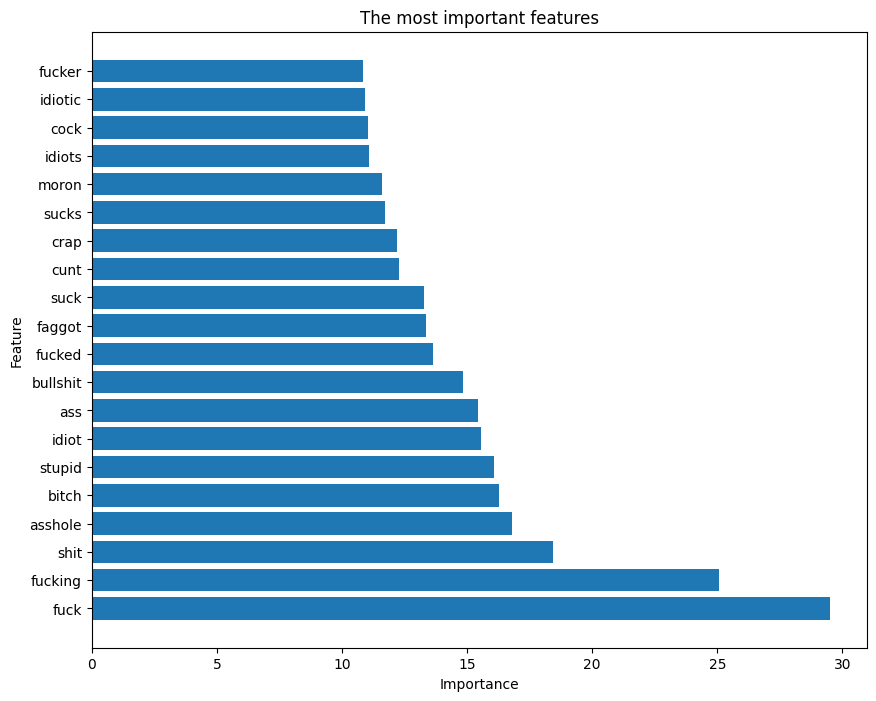

In [69]:
plt.figure(figsize = (10, 8))

plt.barh(top_features['feature'], top_features['coefficient'])

plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('The most important features')
plt.show()

Эти слова внесли наибольший вклад в прогноз, сделанного моделью gs.

# Заключение

Целью задачи было построить модель, которая относит отзывы пользователей к токсичным или нейтральным.

Решение задачи проводилось двумя способами: с помощью нейронной сети BERT и без нее, используя величины TF-IDF в качестве входных признаков.

В первом способе сначала текстовые данные преобразовывались в числовые векторы-эмбеддинги с помощью предобученной модели "unitary/toxic-bert",
а затем на основе полученных числовых признаков подбиралась оптимальная модель для задачи классификации.

Важной особенностью задачи был сильный дисбаланс классов: токсичных отзывов в исходной выборке была только десятая часть.

Оптимальная модель подобрана с помощью случайного поиска, на этапе тестирования наилучшая модель выдала метрику f1 0.94 - больше требуемой.

Во втором способе текст был очищен от ненужных симловов и стоп-слов и лемматизирован. Итоговый пайплайн включал в себя преобразование текста в матрицу числовых данных (CountVectorizer), преобразование в матрицу значений TF-IDF (TfidfTransformer) и модель логистической регресии.

С помощью GridSearchCV был произведен подбор гиперпараметров логистической регрессии. Наилучшая найденная модель выдала метрику f1 на тесте 0.76 - гораздо меньше, чем BERT, но формально она удовлетворяет требованиям.

Для найденной модели выведены слова, которые внесли наибольший вклад при классификации отзывов на нейтральные и токсичные.

Таким образом, задача классификации отзывов решена двумя способами, BERT показала отличный результат, хотя для ее работы исходную выборку пришлось сократить до 800 строк, для которых подсчет эмбеддингов занял 25 минут.
Этот аспект тоже нужно учитывать при выборе модели обработки текстов.